# Exercise 12: The nucleon-nucleon 2-point function

#### The nucleon-nucleon 2-point function data shared via email are divided in directories: each directory contains the 2-point function for a given gauge ensemble. The name of the directory contains information about the lattice size and the κ values for the Nf = 2 light sector (κud) and for the strange quark (κs). Additioanl information about the 16, 20 and 28 ensembles can be found in "https://www.jldg.org/ildg-data/CPPACS+JLQCDconfig.html". For the large volumes ensembles consult "http://www.jldg.org/ildg-data/PACSCSconfig.html".

#### Perform the following analysis using bootstrap (or jackknife) to evaluate statistical uncertainties:

 • Calculate the euclidean time dependence of each correlator and plot them.

 • Calculate the effective mass of each correlator as a function of Euclidean time and plot them.

 • Perform a constant fit where the effective mass plateaus and plot the extracted mass as a function of the pion mass and pion mass squared (pion masses can be found on the links above).
 
 • Plot the extracted mass from the previous analysis as a function of the lattice spacing squared (values of the lattice spacings can be found in the links above).

##### Exercise compiled by Prof. Andrea Shindler for the 2023 Summer School on Methods of Effective Field Theory and Lattice Field Theory @ Physikzentrum Bad Honnef.

##### Solution Notebook by Juan Fernandez

Availability of correlators data upon request: [personal email](mailto:juanfernandezdlg@gmail.com), [academic email](mailto:jfernande@ethz.ch)

# Part 1 of the solution

I use a conda environment (''`badHonnef`'') for this problem. If you do not have conda installed, it is easily done so via the `miniconda` pkg installer, [guide available here](https://docs.conda.io/en/latest/miniconda.html).

After the installation, the environment can be configured with the following commands in the terminal. For compatibility reasons with pyerrors, I use `Python 3.10.12`.
```
conda create -n badHonnef python=3.10.12
conda activate badHonnef
conda install matplotlib=3.7.1
conda install scipy=1.10.1
conda install -c conda-forge pyerrors=2.9.0
conda install -c conda-forge ipympl=0.9.3                                    # For plots in the notebook via 'widget'
conda install -c conda-forge uncertainties=3.1.7                             # For displaying errors with the (ee) convention
conda install -n badHonnef ipykernel=6.25.0 --update-deps --force-reinstall  # Interactive Python Kernel for the notebook
```


In [1]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import pyerrors as pe # The package has a repository with the implementation, documentation and more info in https://github.com/fjosw/pyerrors
# change widget to inline if problematic:
%matplotlib widget

# Pyerrors ref: Joswig, F., Kuberski, S., Kuhlmann, J. T., & Neuendorf, J. (2023). pyerrors: A python framework for error analysis of Monte Carlo data. Computer Physics Communications, 288, 108750. https://doi.org/10.1016/j.cpc.2023.108750

In [2]:
# Close all previously opened figures
plt.close('all')

In [3]:
# Columns to import
colnames = ['p000', 'p100', 'p110', 'p111', 'p200']

# To process directory with csv files
def process_csv_files(directory, fileNames):
    data_arrays = {} # init data frame collection

    ct = 0 # counter 
    for file in fileNames: # loop over files
        file_path = os.path.join(directory, file)
        data_arrays[ct] = pd.read_csv(file_path, na_filter= False,usecols=colnames)
        data_arrays[ct]*=10**25 ## Rescale numbers to prevent underflow
        ct += 1

    return data_arrays

## Input: Select directory and series to analyse

In [4]:
corr_directory = './TALENT_data/RC16x32_Kud01382500Ks01371000/CPEvenism64_jsm64_txt' # Here we introduce the directory where the series are stored
corr_series = 'C2-1'  # Here we choose the series we want to analyse

## Data processing and pandas dataframes initialization

In [5]:
csv_files = sorted(filter(lambda x: x.startswith(corr_series), filter(lambda x: os.path.isfile(os.path.join(corr_directory, x)), os.listdir(corr_directory)))) # OK: files sorted by name alphabetically
df_collection = process_csv_files(corr_directory, csv_files) # OK: dfs correctly init

## Rename unnamed column to time 't' OK: (Not really necessary)
for i, df in df_collection.items():
    df.columns = ['p000', 'p100', 'p110', 'p111', 'p200']

### In the dataframe, we've got correlators tracked in Euclidean time at each configuration in a given series, we can plot individual samples with the following cell:

In [6]:
print(df_collection[1])

            p000          p100          p110          p111          p200
0   149204.74213  99082.770316  67609.284142  47247.960923  32858.100799
1   22048.334805  12104.697347   6858.790198   3948.679469   2486.792445
2    8771.037382   4480.226868   2387.894991   1309.340139    749.963071
3    3264.772952   1443.825724    651.269347    295.399313    175.295535
4    1280.080733    490.327942    181.084501     58.273627     39.100158
5     569.813439    210.952925     87.305746      38.69195      1.639899
6     250.276328     77.418516     27.494274     14.160166       1.91855
7      87.245995     25.678362       7.63302      2.014179      0.100139
8      34.146373      8.939922      3.296025      0.576348      0.531074
9       9.651614      2.551267      0.861701      0.425544      0.420614
10      4.203907      1.171642       0.30268      0.227961      0.155634
11      1.846567      0.348219      0.070362       0.09516     -0.010448
12      0.968918      0.119576      0.011032      0

<Axes: >

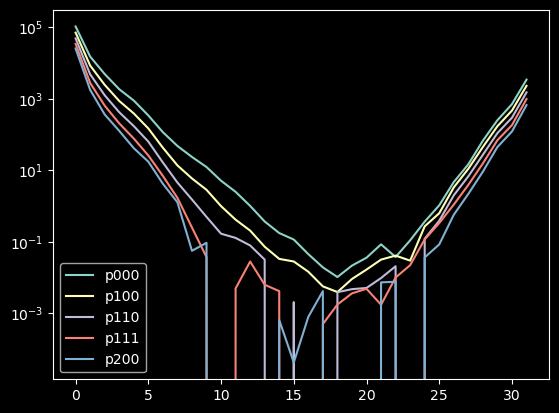

In [7]:
## Define config number (in natural ordering {0,1,2,3,4,...}, NOT in the naming scheme for the configs (e.g.{410,420,....}))
config = 0
corr_to_plot = ['p000', 'p100', 'p110', 'p111', 'p200']

# Plot OK
df_collection[config].plot(y=corr_to_plot, logy=True) # OK: plot works but negative values in correlators make this plot weird...

## Setting up pyerrors observable class

In [8]:
## Select ONE correlator (options: 'p000', 'p100', 'p110', 'p111', 'p200'). Recall each of the runs is comparing different momenta in xyz directions.
corrName = 'p000'

In [9]:
NS = len(df_collection) # number of samples
NT = len(df_collection[0][corrName]) # number of time-slices
peObs = [0]*NT
listNames = [corrName]
## For each time slice
for t in range(NT):
    listArrays = [np.zeros(NS)]
    for k in range(NS):
        listArrays[0][k] = df_collection[k][corrName][t]
    
    peObs[t] = pe.Obs(listArrays,listNames)

## Jackknife analysis

Using `export_jackknife()` we can straightforwardly obtain the jackknife samples. For a reference on the method used in this notebook, consult [the package reference](https://fjosw.github.io/pyerrors/pyerrors/obs.html#Obs.export_jackknife). Note that `export_jackknife()` method is obtaining Jackknife samples as described in Gattringer and Lang's "Quantum Chromodynamics on the lattice" (Chapter 4.5.3). For a quick reference on the method with general binning sizes, refer to and DeGrand and DeTar's "Lattice Methods Quantum Chromodynamics" (Chapter 9.2.3) or Matthias Troyer's [lecture notes on Computational Physics](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjhjY26i8OAAxWDhP0HHfxRDRwQFnoECBMQAQ&url=https%3A%2F%2Farchive.org%2Fdetails%2FMatthias_Troyer___Computational_Physics&usg=AOvVaw0BlqT8qcfDn_F8HE_JigIV&opi=89978449) (Chapter 5.5.3).

As for the analysis to obtain the fitted masses in this Noteboo, Lüscher's [CERN-PH-TH/2010-047 Computational Strategies in Lattice QCD](https://luscher.web.cern.ch/luscher/lectures/LesHouches09.pdf) Chapter 4 is followed.

First we generate the Jackknife Samples for our correlators (i.e. $C^{(i)}_{p}(t) | i \in \{1,2,...,N_S\} \xrightarrow{JackKnife} C^{(j)}_{p}(t) | j \in \{0,1,2,...,N_S\}$)

In [10]:
jackSamples = np.zeros([NT,NS+1])  # initialize lists

for k in range(NT):
    jackSamples[k,:] = peObs[k].export_jackknife()  # obtain Jackknife samples for each time-slice with PyErrors

We can plot the Jackknife samples and compare with the bare samples

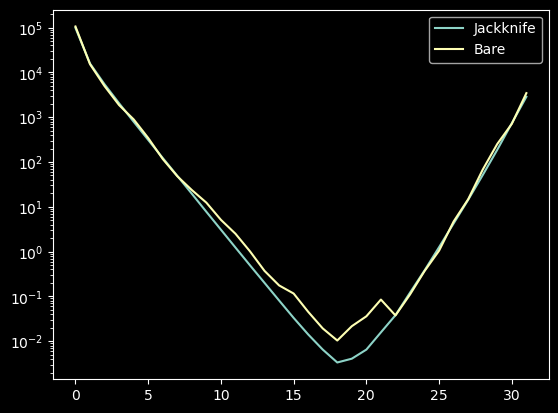

In [11]:
plt.figure()
plt.plot(jackSamples[:,0])
plt.plot(df_collection[0][corrName][:])
plt.legend(['Jackknife','Bare'])
plt.yscale('log')
plt.show()

The `jackSamples` list of arrays contains the bare average ($0^{th}$ element), and Jackknife samples for each time-slice. In order to obtain the estimation of the mass, we perform the constant fit on the bare average and the Jackknife samples $$ am_{eff}(t) = log(\overline{C}(t) / \overline{C}(t+1)) \equiv  log({C^J_{j=0}}(t) / C^J_{j=0}(t+1)) $$ and $$ am_{eff}^J(t)_j = log({C^J_j}(t) / {C^J_j}(t+1)) | j \in \{1,2,...,N_S\} $$

Now we can obtain the covariance estimator: $$ C^{J}_{t,t'} = \sum_{j=1}^{N_S} (am_{eff}^J(t)_j - am_{eff}(t)) (am_{eff}^J(t')_j - am_{eff}(t')) \equiv \sum_{j=1}^{N_S} (am_{eff}^J(t)_j - am_{eff}^J(t)_{0}) (am_{eff}^J(t')_j - am_{eff}^J(t')_{0}) $$

Where the physical mass can be fitted in the plateau region $t\in [t1,t2 ]$ of $am_{eff}(t)$ by minimizing the $\chi^2$ statistic:

$$\chi^2 = \sum_{t=t1}^{t2} \sum_{t'=t1}^{t2} (m_{\textnormal{phys}} - m_{eff}(t)) [(C^J)^{-1}]_{t,t'} (m_{\textnormal{phys}} - m_{eff}(t')) $$

$$ \implies am_{\textnormal{phys}} = \frac{\sum_{t=t1}^{t2} \sum_{t'=t1}^{t2} [(C^J)^{-1}]_{t,t'}\, am_{eff}(t')}{ \sum_{t=t1}^{t2} \sum_{t'=t1}^{t2} [(C^J)^{-1}]_{t,t'} }.$$

Performing the Jackknife method on the $am_{\textnormal{phys}}$ estimator allows us to obtain a bias-corrected estimation, and it's error.

$$ am^J_{\textnormal{phys}}(j) = \frac{\sum_{t=t1}^{t2} \sum_{t'=t1}^{t2} [(C^J)^{-1}]_{t,t'}\, am^J_{eff}(t')_j}{ \sum_{t=t1}^{t2} \sum_{t'=t1}^{t2} [(C^J)^{-1}]_{t,t'} } \,|\, j \in \{1,2,...,N_S\}$$

$$ \overline{am^{{J}}_{\textnormal{phys}}} := \frac{1}{N_S} \sum_{j=1}^{N_S} am^J_{\textnormal{phys}}(j). $$

Thus, the bias corrected estimation is

$$ am^*_{\textnormal{phys}} = N_S\, am_{\textnormal{phys}} - (N_S-1)\overline{am^{{J}}_{\textnormal{phys}}}, $$

and the estimated standard deviation is

$$ \sigma_{am_{\textnormal{phys}}} = \sqrt{ \frac{N_S-1}{N_S} \sum_{j=1}^{N_S} (am^J_{\textnormal{phys}}(j) - \overline{am^{{J}}_{\textnormal{phys}}} )^2 }. $$

### Functions are defined for this analysis:

In [12]:
# To compute Jackknife Error from samples
def jackKnifeError(array):
    N = len(array)
    r = 0
    for k in range(N-1):
        r += (array[k+1] - array[0])**2
    return np.sqrt( ((N - 1)/N) * r )

# To compute Covariance matrix
def CovJ(array):
    # array is a NT x (NS+1) array
    NT,NS = np.shape(array)
    r = np.zeros([NT,NT])
    for k in range(NS-1):
        r += (array[:,k+1] - array[:,0]).reshape(NT,1) @ (array[:,k+1] - array[:,0]).reshape(1,NT)
    return r

# To compute Chi2 statistic
def chi2(avg, array, cov):
    return (avg - array) @ np.linalg.inv(cov) @ (avg - array).T

# To perform the Chi2 fit on the plateau region( given by [startIdx:endIdx] )
def chi2fit(array, cov, start, end):
    workArray = array[start:end]
    ones = np.ones([1,len(workArray)])
    covinv = np.linalg.inv(cov)[start:end,start:end]
    return ((ones @ covinv @ workArray)/(ones @ covinv @ ones.T))[0,0] # [0,0] to 'convert' from 1x1 np array to scalar


### Obtain Jackknife effective masses and their errors:

In [13]:

am_effJack = np.zeros([NT-1,NS+1]) # note: elem, [:,0] is the bare average
am_effJack_Error = np.zeros(NT-1)

for s in range(NS+1):
    for t in range(NT-1):
        # This should be possible with a np.vectorize and .diff upon re-factoring jackSamples into an np.array. For now this works OK:
        am_effJack[t,s] = np.log((jackSamples[t,s]) / (jackSamples[t+1,s])) 

for t in range(NT-1):
    am_effJack_Error[t] = jackKnifeError(am_effJack[t,:])


### Plot the effective mass to see where the plateau is located:

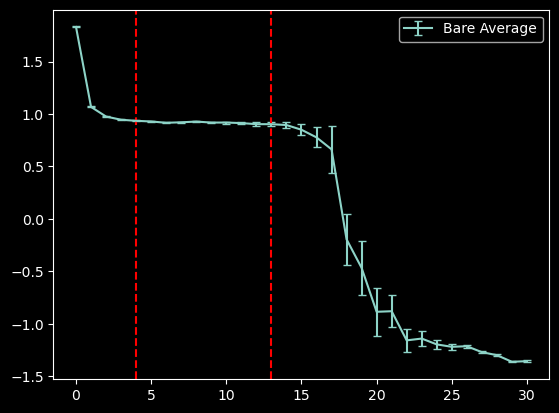

In [14]:
# Seems OK: But the values after t=12 seem odd. Expectable symmetry around t ~ NT/2
plt.figure()
plt.errorbar(range(len(am_effJack_Error)),am_effJack[:,0], yerr=am_effJack_Error[:], label='Bare Average', capsize=3)
plt.axvline(x=4, color='r', linestyle='--')
plt.axvline(x=13, color='r', linestyle='--')
plt.legend()
plt.show()

In [15]:
# Define the plateau region
startIdx = 4
endIdx = 14

# Obtain Covariance matrix
CovJtt = CovJ(am_effJack)

# Obtain chi2 fits
am_fit = np.zeros(NS+1)
for k in range(NS+1):
    am_fit[k] = chi2fit(am_effJack[:,k], CovJtt, startIdx, endIdx)

# Estimate fits error and bias-corrected estimates
am_fit_biasCorrected = NS * am_fit[0] - (NS-1)*np.mean(am_fit[1:])
am_fit_error = jackKnifeError(am_fit)

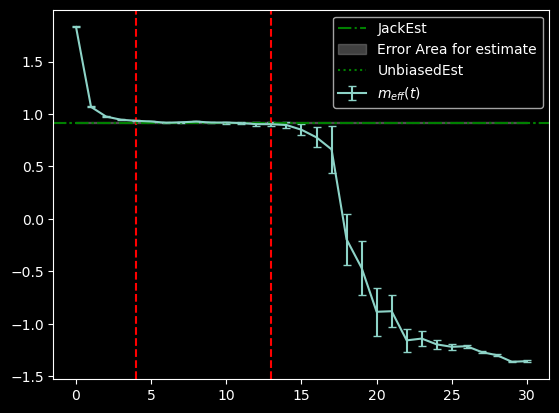

In [16]:
# Replot
plt.figure()
plt.errorbar(range(len(am_effJack_Error)),am_effJack[:,0], yerr=am_effJack_Error[:], label=r'$m_{eff}(t)$', capsize=3)
plt.axvline(x=startIdx, color='r', linestyle='--')
plt.axvline(x=endIdx-1, color='r', linestyle='--')
plt.axhline(y=am_fit[0], color='g', linestyle='-.', label='JackEst')
plt.fill_between(range(31),am_fit[0]-am_fit_error, am_fit[0]+am_fit_error, color='gray', alpha=0.5, label='Error Area for estimate')
plt.axhline(y=am_fit_biasCorrected, color='g', linestyle=':', label='UnbiasedEst')
plt.legend()
plt.show()

### The final value to be reported is the Jackknife estimation +/- the Jackknife error estimation (bias corrected value seems to be over-corrected)

In [17]:
from uncertainties import ufloat
print("Effective mass is estimates to be: " + str(am_fit[0]) + " and the St. Dev. " + str(am_fit_error))
print(" => Mass = " + f"{ufloat(am_fit[0],am_fit_error):.2uS}")

Effective mass is estimates to be: 0.9189814995956237 and the St. Dev. 0.0035348789072908835
 => Mass = 0.9190(35)


## Via PyErrors & Gamma method

##### In this section we'll perform the gamma analysis of the samples. Recall that in a previous cell we defined `corr_series` to select the series we want to analyse, and `df_collection` stores all the correlator data.

In [18]:
corr = pe.Corr(peObs)

In [19]:
am_eff = corr.m_eff(variant='log')
am_eff.gamma_method()

In [20]:
am = am_eff.plateau(plateau_range=[4,12],method='fit')
am.gamma_method()
print(am)

Fit with 1 parameter
Method: Levenberg-Marquardt
`ftol` termination condition is satisfied.
chisquare/d.o.f.: 1.631398846113349
fit parameters [0.92537249]
0.9254(27)


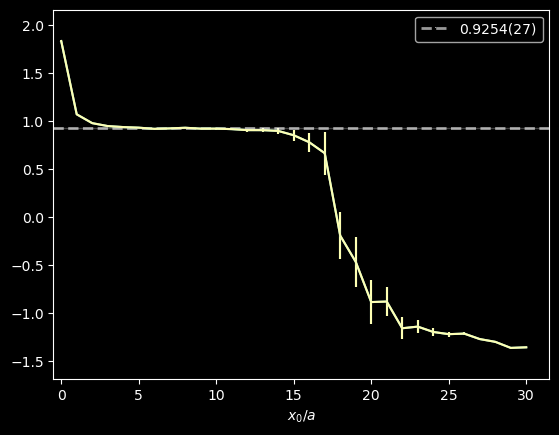

In [21]:
am_eff.show(comp=am_eff, plateau=am)

Note how the Jackknife analysis and the Gamma Method from PyErrors compare:

$$ am^{p000}_{\Gamma} = 0.9254(27) $$

$$ am^{p000}_{JK} = 0.9190(35) $$

# For the choice of configuration set in this notebook as presented:
(corr_directory = './TALENT_data/RC16x32_Kud01382500Ks01371000/CPEvenism64_jsm64_txt')

From [the JLDG website](https://www.jldg.org/ildg-data/CPPACS+JLQCDconfig.html), this corresponds to config #5:
### $\beta = 1.83$, $\kappa_{ud} = 0.1382500 $, $\kappa_s = 0.1371000$, $\beta = 1.83$, $c_{SW} = 1.7610$. With $a = 0.1209(16)_K// 0.1219(19)_{\phi} \text{fm} \implies L = 1.934(26)_K// 1.950(30)_{\phi} \text{fm}$

Recall that in natural units, $1 \text{fm}^{-1} \equiv 197.3 \text{MeV}$, thus the mass can be related as $m = am^{p}/a = 0.9254/0.1209 \,\cdot 197.3\,\text{MeV} = 1510 \,\text{MeV}$.

### The analysis can be carried out sistematically for all ensembles and momentums with Jackknife / Gamma method. Obtaining the spectra for the different choices of $\beta, \kappa_{ud/s}$ (thus $a$). And allowing further analysis. (This is done in part 2)